Import nessecary dependencies

In [309]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import re
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import seaborn as sns

The unemployment dataset is as TSV (tab separated format) file. We use read_csv with \t separator for reading the data.

In [310]:
data_df = pd.read_csv("datasets/une_rt_m.tsv", sep='\t')
data_df.head()

,"s_adj,age,unit,sex,geo\time",2020M07,2020M06,2020M05,2020M04,2020M03,2020M02,2020M01,2019M12,2019M11,...,1983M10,1983M09,1983M08,1983M07,1983M06,1983M05,1983M04,1983M03,1983M02,1983M01
0,"NSA,TOTAL,PC_ACT,F,AT",6.0,6.2,5.2,4.9,4.7,4.1,4.4,4.0,3.9,...,:,:,:,:,:,:,:,:,:,:
1,"NSA,TOTAL,PC_ACT,F,BE",5.4,5.0,5.0,5.2,5.0,4.9,4.8,4.6,4.5,...,:,:,:,:,:,:,:,:,:,:
2,"NSA,TOTAL,PC_ACT,F,BG",3.9,3.9,4.2,4.7,4.1,4.2,4.3,3.9,3.8,...,:,:,:,:,:,:,:,:,:,:
3,"NSA,TOTAL,PC_ACT,F,CH",:,4.4,4.3,4.4,4.6,4.6,4.5,4.1,4.0,...,:,:,:,:,:,:,:,:,:,:
4,"NSA,TOTAL,PC_ACT,F,CY",7.2,6.6,6.4,6.8,7.1,7.5,7.9,7.5,7.7,...,:,:,:,:,:,:,:,:,:,:


In [311]:
data_df.shape

(2131, 452)

Read the contry codes data from csv file.

In [312]:
country_codes_df = pd.read_csv("datasets/wikipedia-iso-country-codes.csv")
country_codes_df.columns = ['Country', 'C2', 'C3', 'Numeric', 'Iso']
country_codes_df.head()

,Country,C2,C3,Numeric,Iso
0,Zimbabwe,ZW,ZWE,716,ISO 3166-2:ZW
1,Zambia,ZM,ZMB,894,ISO 3166-2:ZM
2,Yemen,YE,YEM,887,ISO 3166-2:YE
3,Western Sahara,EH,ESH,732,ISO 3166-2:EH
4,Wallis and Futuna,WF,WLF,876,ISO 3166-2:WF


Categorize the data in several dimensions, including country, age, unit, sex and s_adj.

In [313]:
        
data_df['C2'] = data_df['s_adj,age,unit,sex,geo\\time'].apply(lambda x: x.split(",")[-1])
data_df['age'] = data_df['s_adj,age,unit,sex,geo\\time'].apply(lambda x: x.split(",")[1])
data_df['unit'] = data_df['s_adj,age,unit,sex,geo\\time'].apply(lambda x: x.split(",")[2])
data_df['sex'] = data_df['s_adj,age,unit,sex,geo\\time'].apply(lambda x: x.split(",")[3])
data_df['s_adj'] = data_df['s_adj,age,unit,sex,geo\\time'].apply(lambda x: x.split(",")[0])

data_df.head()

,"s_adj,age,unit,sex,geo\time",2020M07,2020M06,2020M05,2020M04,2020M03,2020M02,2020M01,2019M12,2019M11,...,1983M05,1983M04,1983M03,1983M02,1983M01,C2,age,unit,sex,s_adj
0,"NSA,TOTAL,PC_ACT,F,AT",6.0,6.2,5.2,4.9,4.7,4.1,4.4,4.0,3.9,...,:,:,:,:,:,AT,TOTAL,PC_ACT,F,NSA
1,"NSA,TOTAL,PC_ACT,F,BE",5.4,5.0,5.0,5.2,5.0,4.9,4.8,4.6,4.5,...,:,:,:,:,:,BE,TOTAL,PC_ACT,F,NSA
2,"NSA,TOTAL,PC_ACT,F,BG",3.9,3.9,4.2,4.7,4.1,4.2,4.3,3.9,3.8,...,:,:,:,:,:,BG,TOTAL,PC_ACT,F,NSA
3,"NSA,TOTAL,PC_ACT,F,CH",:,4.4,4.3,4.4,4.6,4.6,4.5,4.1,4.0,...,:,:,:,:,:,CH,TOTAL,PC_ACT,F,NSA
4,"NSA,TOTAL,PC_ACT,F,CY",7.2,6.6,6.4,6.8,7.1,7.5,7.9,7.5,7.7,...,:,:,:,:,:,CY,TOTAL,PC_ACT,F,NSA


Let's see the data.

In [314]:
print(f"countries:\n{list(data_df.C2.unique())}")

countries:
['AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EA', 'EA18', 'EA19', 'EE', 'EL', 'ES', 'EU25', 'EU27_2007', 'EU27_2020', 'EU28', 'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT', 'JP', 'LT', 'LU', 'LV', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'UK', 'US', 'TR']


In [315]:
print(f"sex:\n{list(data_df.sex.unique())}")

sex:
['F', 'M', 'T']


In [316]:
print(f"age intervals:\n{list(data_df.age.unique())}")

age intervals:
['TOTAL', 'Y25-74', 'Y_LT25']


In [317]:
print(f"unit:\n{list(data_df.unit.unique())}")

unit:
['PC_ACT', 'THS_PER']


In [318]:
print(f"s_adj:\n{list(data_df.s_adj.unique())}")

s_adj:
['NSA', 'SA', 'TC']


We select only a part of columns for further analysis.
More specificaly, we are selecting country code (2 letters), age, unit, sex, s_adj and months from Jan 2010 to June 2020.

In [319]:
selected_cols = ['C2','age','unit','sex', 's_adj', 
                '2020M07 ', '2020M06 ', '2020M05 ', '2020M04 ','2020M03 ','2020M02 ','2020M01 ',
                '2019M12 ','2019M11 ','2019M10 ','2019M09 ','2019M08 ','2019M07 ',
                '2019M06 ','2019M05 ','2019M04 ','2019M03 ','2019M02 ','2019M01 ',
                '2018M12 ','2018M11 ','2018M10 ','2018M09 ','2018M08 ','2018M07 ',
                '2018M06 ','2018M05 ','2018M04 ','2018M03 ','2018M02 ','2018M01 ',
                '2017M12 ','2017M11 ','2017M10 ','2017M09 ','2017M08 ','2017M07 ',
                '2017M06 ','2017M05 ','2017M04 ','2017M03 ','2017M02 ','2017M01 ',
                '2016M12 ','2016M11 ','2016M10 ','2016M09 ','2016M08 ','2016M07 ',
                '2016M06 ','2016M05 ','2016M04 ','2016M03 ','2016M02 ','2016M01 ',
                '2015M12 ','2015M11 ','2015M10 ','2015M09 ','2015M08 ','2015M07 ',
                '2015M06 ','2015M05 ','2015M04 ','2015M03 ','2015M02 ','2015M01 ',
                '2014M12 ','2014M11 ','2014M10 ','2014M09 ','2014M08 ','2014M07 ',
                '2014M06 ','2014M05 ','2014M04 ','2014M03 ','2014M02 ','2014M01 ',
                '2013M12 ','2013M11 ','2013M10 ','2013M09 ','2013M08 ','2013M07 ',
                '2013M06 ','2013M05 ','2013M04 ','2013M03 ','2013M02 ','2013M01 ',
                '2012M12 ','2012M11 ','2012M10 ','2012M09 ','2012M08 ','2012M07 ',
                '2012M06 ','2012M05 ','2012M04 ','2012M03 ','2012M02 ','2012M01 ',
                '2011M12 ','2011M11 ','2011M10 ','2011M09 ','2011M08 ','2011M07 ',
                '2011M06 ','2011M05 ','2011M04 ','2011M03 ','2011M02 ','2011M01 ',
                '2010M12 ','2010M11 ','2010M10 ','2010M09 ','2010M08 ','2010M07 ',
                '2010M06 ','2010M05 ','2010M04 ','2010M03 ','2010M02 ','2010M01 ',]
data_sel_df = data_df[selected_cols]

Merge the unemployment data with the country codes data.

In [320]:
data_sel_df = data_sel_df.merge(country_codes_df, on="C2")
data_sel_df.head()

,C2,age,unit,sex,s_adj,2020M07,2020M06,2020M05,2020M04,2020M03,...,2010M06,2010M05,2010M04,2010M03,2010M02,2010M01,Country,C3,Numeric,Iso
0,AT,TOTAL,PC_ACT,F,NSA,6.0,6.2,5.2,4.9,4.7,...,4.5,4.5,5.0,4.5,4.9,4.5,Austria,AUT,40,ISO 3166-2:AT
1,AT,TOTAL,PC_ACT,M,NSA,5.5,6.2,6.1,5.2,5.0,...,5.0,4.9,5.5,6.2,6.0,5.2,Austria,AUT,40,ISO 3166-2:AT
2,AT,TOTAL,PC_ACT,T,NSA,5.7,6.2,5.7,5.1,4.9,...,4.7,4.8,5.2,5.4,5.5,4.9,Austria,AUT,40,ISO 3166-2:AT
3,AT,TOTAL,THS_PER,F,NSA,129,132,108,100,97,...,76,93,104,76,100,93,Austria,AUT,40,ISO 3166-2:AT
4,AT,TOTAL,THS_PER,M,NSA,134,149,144,121,118,...,95,118,133,120,142,122,Austria,AUT,40,ISO 3166-2:AT


Data transforming.

Use melt method to pivot time series columns. For each value of time series we introduce additional rows.

In [321]:
data_tr_df = data_sel_df.melt(id_vars=["Country", "age", "unit", "sex", "s_adj", "C2", "C3", "Numeric", "Iso"], 
        var_name="Date", 
        value_name="Unemployment_Rate")

data_tr_df.head()

,Country,age,unit,sex,s_adj,C2,C3,Numeric,Iso,Date,Unemployment_Rate
0,Austria,TOTAL,PC_ACT,F,NSA,AT,AUT,40,ISO 3166-2:AT,2020M07,6.0
1,Austria,TOTAL,PC_ACT,M,NSA,AT,AUT,40,ISO 3166-2:AT,2020M07,5.5
2,Austria,TOTAL,PC_ACT,T,NSA,AT,AUT,40,ISO 3166-2:AT,2020M07,5.7
3,Austria,TOTAL,THS_PER,F,NSA,AT,AUT,40,ISO 3166-2:AT,2020M07,129
4,Austria,TOTAL,THS_PER,M,NSA,AT,AUT,40,ISO 3166-2:AT,2020M07,134


The shape of data before and after melt.

In [322]:
print(f"Data shape before melt {data_sel_df.shape}")
print(f"Data shape after melt {data_tr_df.shape}")

Data shape before melt (1645, 136)
Data shape after melt (208915, 11)


Cleaning the data. We remove the non-digit data and trim the spaces.

In this dataset the null values are presented as ": ", so we check how many null values we have in this specific column.

In [323]:
count = (data_tr_df['Unemployment_Rate'] == ': ').sum()
print(f"Number of ':' values in 'Unemployment_Rate': {count}")

Number of ':' values in 'Unemployment_Rate': 2903


We have a small amount of data that are null we choose to delete those data and keep the integrity, since it will not effect the analysis result.

In [324]:
data_tr_df['Unemployment_Rate'] = data_tr_df['Unemployment_Rate'].apply(lambda x: re.sub(r"[a-zA-Z: ]", "", x))
data_tr_df['Unemployment_Rate'] = data_tr_df['Unemployment_Rate'].apply(lambda x: x.replace(" ",""))

data_tr_df = data_tr_df.loc[~(data_tr_df.Unemployment_Rate=="")]

data_tr_df['Unemployment_Rate'] = data_tr_df['Unemployment_Rate'].apply(lambda x: float(x))

In [325]:
print(f"distinct values: {len(list(data_tr_df['Unemployment_Rate'].unique()))}")
print(f"samples values: {data_tr_df['Unemployment_Rate'].unique()}")

distinct values: 5304
samples values: [6.0000e+00 5.5000e+00 5.7000e+00 ... 8.9410e+03 1.4987e+04 1.1059e+04]


Check for any null values

In [326]:
print(data_tr_df.isnull().sum())

Country              0
age                  0
unit                 0
sex                  0
s_adj                0
C2                   0
C3                   0
Numeric              0
Iso                  0
Date                 0
Unemployment_Rate    0
dtype: int64


Check for duplicated data

In [327]:
print('Duplicated data: ',data_tr_df.duplicated().sum())

Duplicated data:  0


Transfrom 'Date' column format.

In [328]:
data_tr_df.to_csv('t2.csv')
data_tr_df['Date'] = pd.to_datetime(data_tr_df['Date'], format='%YM%m ', errors='coerce')

data_tr_df['Month'] = data_tr_df['Date'].dt.strftime('%B')
data_tr_df['Year'] = data_tr_df['Date'].dt.year

data_tr_df = data_tr_df.drop('Date', axis=1)
data_tr_df = data_tr_df[data_tr_df["s_adj"] == "NSA"].drop("s_adj", axis=1)

data_tr_df.head()
data_tr_df.to_csv('t3.csv')

Reorder and format column names.

In [329]:
data_tr_df = data_tr_df[['Country', 'age', 'unit', 'sex', 'C2','C3', 'Numeric', 'Iso', 'Month', 'Year', 'Unemployment_Rate']]

data_tr_df.columns = [col.upper() for col in data_tr_df.columns]

data_tr_df.head()

,COUNTRY,AGE,UNIT,SEX,C2,C3,NUMERIC,ISO,MONTH,YEAR,UNEMPLOYMENT_RATE
0,Austria,TOTAL,PC_ACT,F,AT,AUT,40,ISO 3166-2:AT,July,2020,6.0
1,Austria,TOTAL,PC_ACT,M,AT,AUT,40,ISO 3166-2:AT,July,2020,5.5
2,Austria,TOTAL,PC_ACT,T,AT,AUT,40,ISO 3166-2:AT,July,2020,5.7
3,Austria,TOTAL,THS_PER,F,AT,AUT,40,ISO 3166-2:AT,July,2020,129.0
4,Austria,TOTAL,THS_PER,M,AT,AUT,40,ISO 3166-2:AT,July,2020,134.0


Filter for EU countries.

In [330]:
eu_countries = ['AT','BE','BG','CY','CZ','DE','DK','EE','ES','FI','FR','GR','HR','HU','IE','IT','LT','LU','LV','MT','NL','PO','PT','RO','SE','SI','SK']  # Add the correct EU country codes
data_tr_df = data_tr_df[data_tr_df['C2'].isin(eu_countries)]
data_tr_df.shape

(56968, 11)

Applying Z-Score method to identify outliers.

In [331]:
data_tr_df['Z_Score'] = np.abs(stats.zscore(data_tr_df['UNEMPLOYMENT_RATE'], nan_policy='omit'))
threshold = 3
outliers_z = data_tr_df[data_tr_df['Z_Score'] > threshold]
print("Outliers identified by Z-Score method:")
print(outliers_z.head())

Outliers identified by Z-Score method:
     COUNTRY     AGE     UNIT SEX  C2   C3  NUMERIC            ISO MONTH  \
329  Germany   TOTAL  THS_PER   T  DE  DEU      276  ISO 3166-2:DE  July   
335  Germany  Y25-74  THS_PER   T  DE  DEU      276  ISO 3166-2:DE  July   
489    Spain   TOTAL  THS_PER   F  ES  ESP      724  ISO 3166-2:ES  July   
490    Spain   TOTAL  THS_PER   M  ES  ESP      724  ISO 3166-2:ES  July   
491    Spain   TOTAL  THS_PER   T  ES  ESP      724  ISO 3166-2:ES  July   

     YEAR  UNEMPLOYMENT_RATE   Z_Score  
329  2020             1983.0  3.839939  
335  2020             1665.0  3.170251  
489  2020             1657.0  3.153404  
490  2020             1632.0  3.100756  
491  2020             3289.0  6.590291  


Visualise the outliers identified by Z-Score.

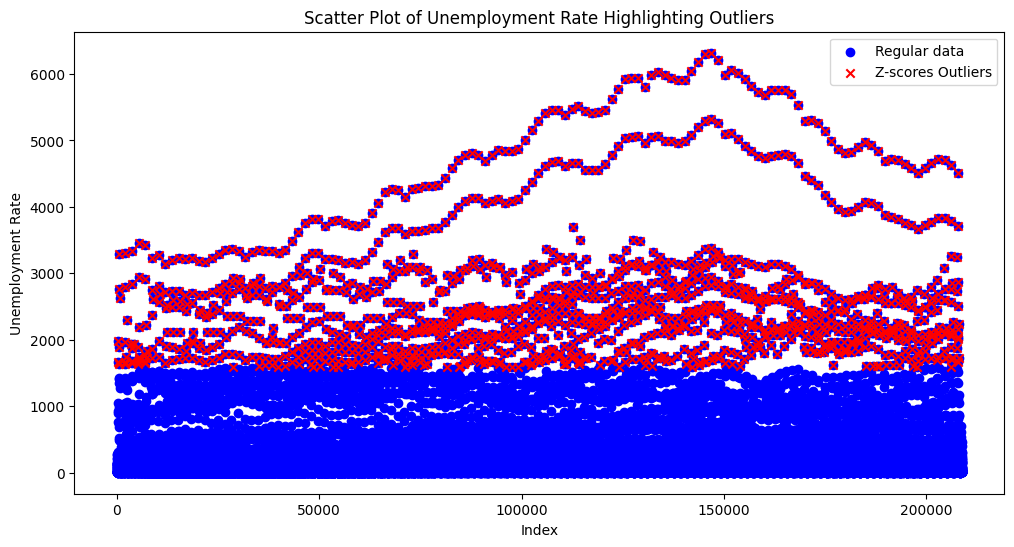

In [332]:
# Scatter plot for all data
plt.figure(figsize=(12, 6))
plt.scatter(data_tr_df.index, data_tr_df['UNEMPLOYMENT_RATE'], color='blue', label='Regular data')

# Scatter plot for outliers
plt.scatter(outliers_z.index, outliers_z['UNEMPLOYMENT_RATE'], color='red', label='Z-scores Outliers',marker='x')
plt.title("Scatter Plot of Unemployment Rate Highlighting Outliers")
plt.xlabel("Index")
plt.ylabel("Unemployment Rate")
plt.legend()
plt.show()

When looking the statistics we identify that the difference between maximum and minimum is big and we analyze further.

In [333]:
print(data_tr_df.describe())

            NUMERIC          YEAR  UNEMPLOYMENT_RATE       Z_Score
count  56968.000000  56968.000000       56968.000000  56968.000000
mean     382.196672   2014.786547         159.611308      0.450331
std      212.792194      3.051924         474.852526      0.892870
min       40.000000   2010.000000           0.000000      0.000819
25%      208.000000   2012.000000           7.700000      0.249156
50%      372.000000   2015.000000          19.200000      0.309175
75%      528.000000   2017.000000          94.000000      0.323706
max      752.000000   2020.000000        6321.000000     12.975487


The observed difference between the maximum and minimum values in the 'Unemployment_Rate' column arises from the inclusion of data measured in both percentage terms and as counts in thousands of people. To facilitate more precise analysis and visualization, it is advantageous to segregate the data into two distinct DataFrames, each corresponding to one of these measurement units.

In [334]:
ts_df_th = data_tr_df[data_tr_df["UNIT"] == "THS_PER"].drop("UNIT", axis=1)  # Thousands Person
data_tr_df = data_tr_df[data_tr_df["UNIT"] == "PC_ACT"].drop("UNIT", axis=1)  # Percentage Active Population
data_tr_df.head(5)

,COUNTRY,AGE,SEX,C2,C3,NUMERIC,ISO,MONTH,YEAR,UNEMPLOYMENT_RATE,Z_Score
0,Austria,TOTAL,F,AT,AUT,40,ISO 3166-2:AT,July,2020,6.0,0.323496
1,Austria,TOTAL,M,AT,AUT,40,ISO 3166-2:AT,July,2020,5.5,0.324548
2,Austria,TOTAL,T,AT,AUT,40,ISO 3166-2:AT,July,2020,5.7,0.324127
6,Austria,Y25-74,F,AT,AUT,40,ISO 3166-2:AT,July,2020,5.2,0.325180
7,Austria,Y25-74,M,AT,AUT,40,ISO 3166-2:AT,July,2020,4.6,0.326444


In [335]:
print(data_tr_df.describe())

            NUMERIC          YEAR  UNEMPLOYMENT_RATE       Z_Score
count  28484.000000  28484.000000       28484.000000  28484.000000
mean     382.196672   2014.786547          12.252352      0.310328
std      212.794062      3.051951           9.029547      0.019016
min       40.000000   2010.000000           1.100000      0.208090
25%      208.000000   2012.000000           6.000000      0.303700
50%      372.000000   2015.000000           9.200000      0.316757
75%      528.000000   2017.000000          15.400000      0.323496
max      752.000000   2020.000000          60.800000      0.333815


Filter data after removing the outliers.

In [336]:
outliers_pct_z = data_tr_df[data_tr_df['Z_Score'] > threshold]
print("Outliers identified by Z-Score method:")
print(outliers_pct_z.head())

Outliers identified by Z-Score method:
Empty DataFrame
Columns: [COUNTRY, AGE, SEX, C2, C3, NUMERIC, ISO, MONTH, YEAR, UNEMPLOYMENT_RATE, Z_Score]
Index: []


Visualize the data after removing outliers using scatter plot.

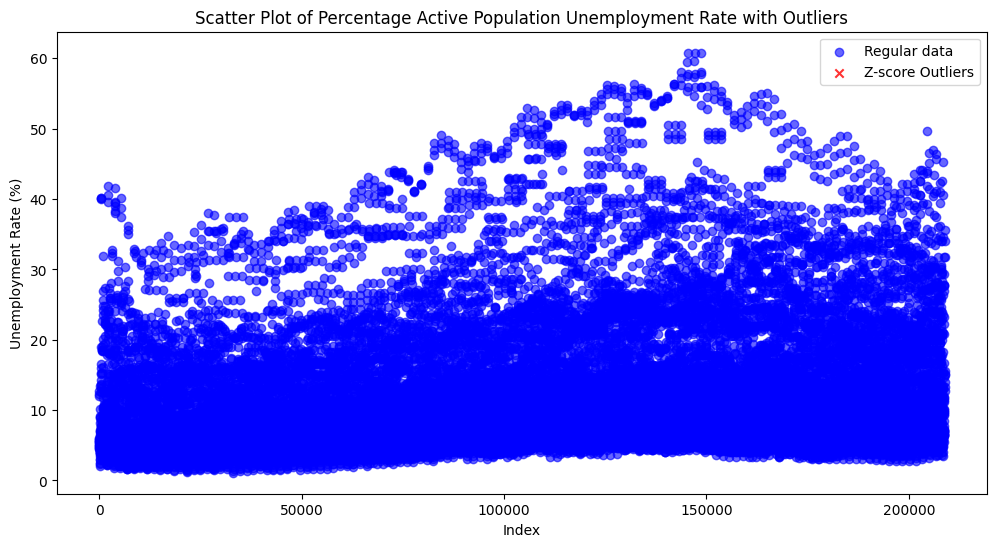

In [337]:
plt.figure(figsize=(12, 6))
plt.scatter(data_tr_df.index, data_tr_df['UNEMPLOYMENT_RATE'], color='blue', label='Regular data', alpha=0.6)
plt.scatter(outliers_pct_z.index, outliers_pct_z['UNEMPLOYMENT_RATE'], color='red', label='Z-score Outliers', alpha=0.8, marker='x')

plt.title("Scatter Plot of Percentage Active Population Unemployment Rate with Outliers")
plt.xlabel("Index")
plt.ylabel("Unemployment Rate (%)")
plt.legend()
plt.show()


Apply SMOTE algorithm to the dataset. Train and test dataset.

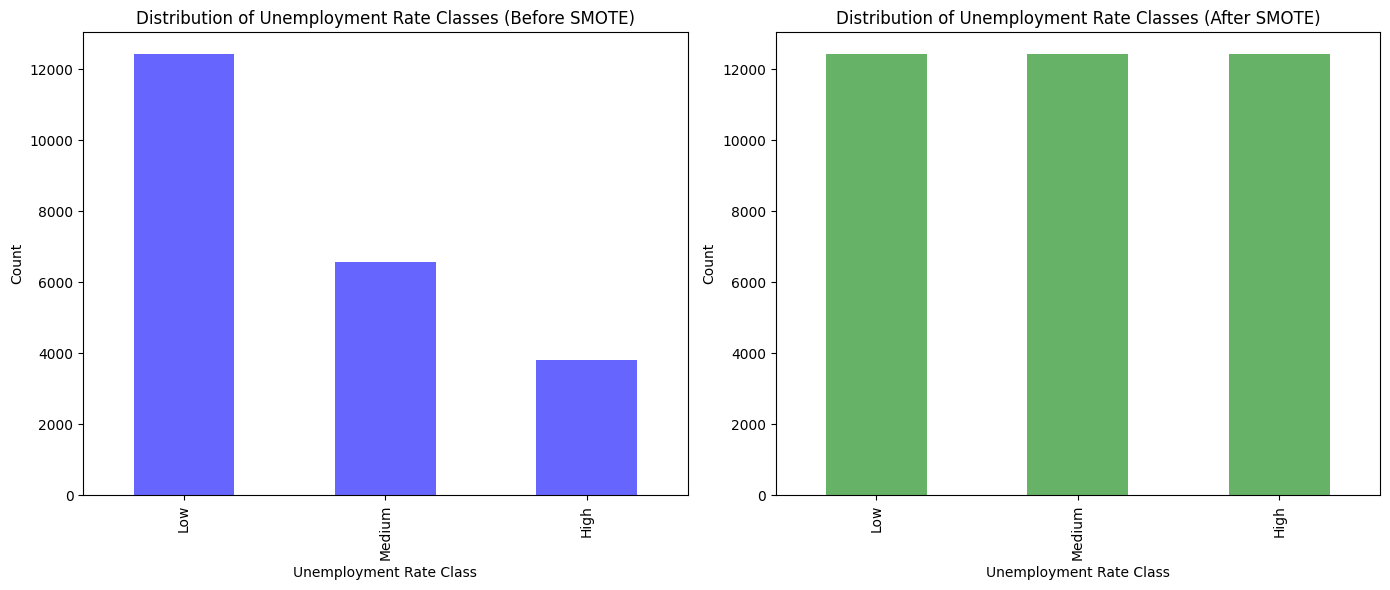

In [338]:
cleaned_df = data_tr_df.drop(['Z_Score'], axis=1)

class_thresholds = [0, 10, 20, float('inf')] 
class_labels = ['Low', 'Medium', 'High']

cleaned_df['CLASS'] = pd.cut(cleaned_df['UNEMPLOYMENT_RATE'], bins=class_thresholds, labels=class_labels, include_lowest=True)

label_encoder = LabelEncoder()
cleaned_df['CLASS_ENCODED'] = label_encoder.fit_transform(cleaned_df['CLASS'])

X = cleaned_df.drop(['UNEMPLOYMENT_RATE', 'CLASS', 'CLASS_ENCODED'], axis=1)
y_class = cleaned_df['CLASS']

label_encoder = LabelEncoder()
X['COUNTRY'] = label_encoder.fit_transform(X['COUNTRY'])
X['AGE'] = label_encoder.fit_transform(X['AGE'])
X['SEX'] = label_encoder.fit_transform(X['SEX'])
X['ISO'] = label_encoder.fit_transform(X['ISO'])
X['MONTH'] = label_encoder.fit_transform(X['MONTH'])
X['YEAR'] = label_encoder.fit_transform(X['YEAR'])
X['C2'] = label_encoder.fit_transform(X['C2'])
X['C3'] = label_encoder.fit_transform(X['C3'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=min(len(y_train[y_train=='Low']), len(y_train[y_train=='Medium']), len(y_train[y_train=='High'])) - 1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

plt.figure(figsize=(14, 6))

# Bar plot before SMOTE
plt.subplot(1, 2, 1)
y_train.value_counts().sort_index().plot(kind='bar', color='blue', alpha=0.6)
plt.title("Distribution of Unemployment Rate Classes (Before SMOTE)")
plt.xlabel("Unemployment Rate Class")
plt.ylabel("Count")

# Bar plot after SMOTE
plt.subplot(1, 2, 2)
y_resampled.value_counts().sort_index().plot(kind='bar', color='green', alpha=0.6)
plt.title("Distribution of Unemployment Rate Classes (After SMOTE)")
plt.xlabel("Unemployment Rate Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

Calculate and visualize the dataset model results.

Accuracy: 0.9192557486396349


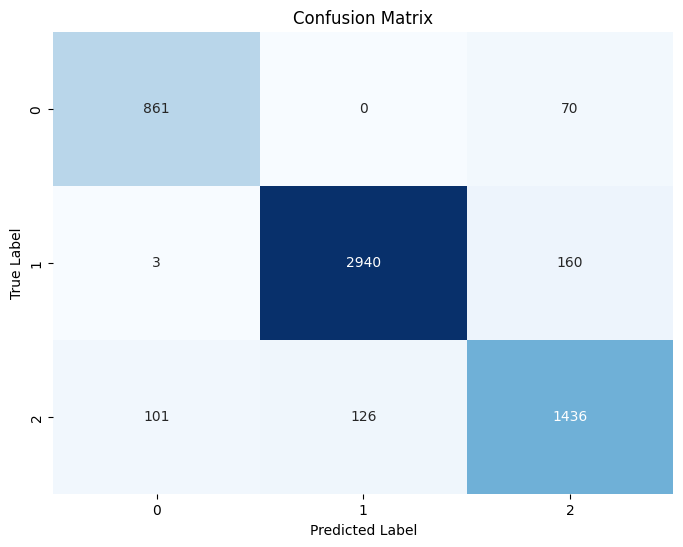

In [339]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)
precision = [classification_rep[label]['precision'] for label in class_labels]
recall = [classification_rep[label]['recall'] for label in class_labels]

print(f"Accuracy: {accuracy}")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Visualize the classification report.

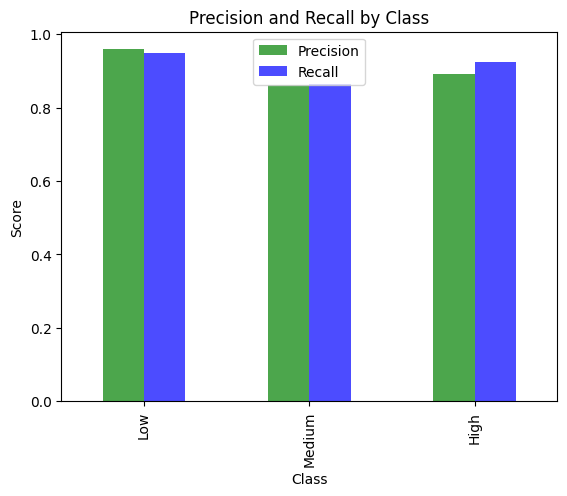

In [340]:
precision_recall_df = pd.DataFrame(data={'Precision': precision, 'Recall': recall}, index=class_labels)
precision_recall_df.plot(kind='bar', color=['green','blue'], alpha=0.7)
plt.title("Precision and Recall by Class")
plt.xlabel("Class")
plt.ylabel("Score")
plt.show()

Check skewness of the 'UNEMPLOYMENT_RATE' column.

After visualizing the mean, median and mode we can see that we have positive skewnees.

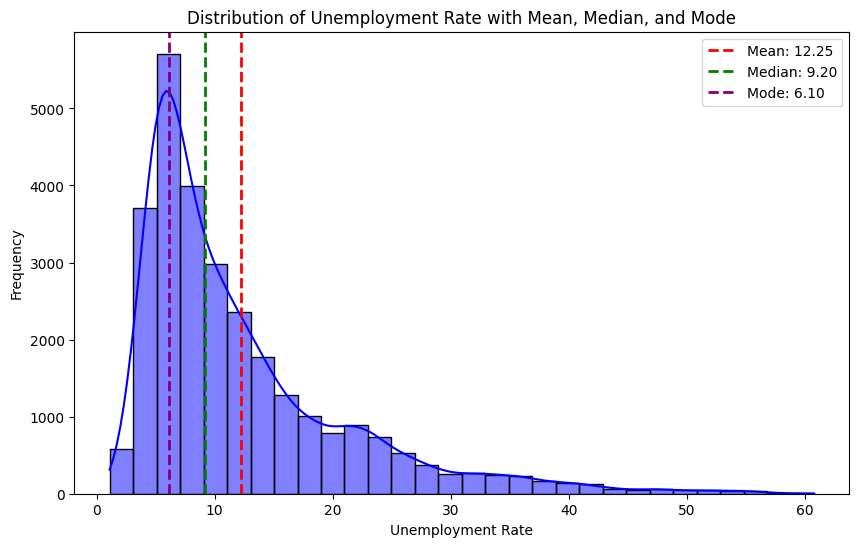

In [341]:
mean_rate = cleaned_df['UNEMPLOYMENT_RATE'].mean()
median_rate = cleaned_df['UNEMPLOYMENT_RATE'].median()
mode_rate = cleaned_df['UNEMPLOYMENT_RATE'].mode()[0]

plt.figure(figsize=(10, 6))
sns.histplot(cleaned_df['UNEMPLOYMENT_RATE'], kde=True, color='blue', bins=30)
plt.axvline(mean_rate, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_rate:.2f}')
plt.axvline(median_rate, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_rate:.2f}')
plt.axvline(mode_rate, color='purple', linestyle='dashed', linewidth=2, label=f'Mode: {mode_rate:.2f}')
plt.title('Distribution of Unemployment Rate with Mean, Median, and Mode')
plt.xlabel('Unemployment Rate')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Apply skew() method to check the skeweed data in 'UNEMPLOYMENT_RATE' column.

Skewness of UNEMPLOYMENT_RATE: 1.7791506055597557


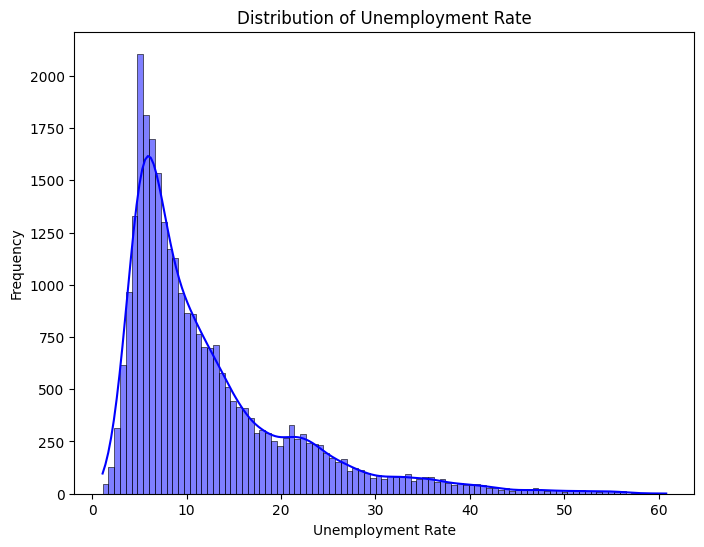

In [342]:
skewness = data_tr_df['UNEMPLOYMENT_RATE'].skew()
print(f"Skewness of UNEMPLOYMENT_RATE: {skewness}")

plt.figure(figsize=(8, 6))
sns.histplot(cleaned_df['UNEMPLOYMENT_RATE'], kde=True, color='blue')
plt.title('Distribution of Unemployment Rate')
plt.xlabel('Unemployment Rate')
plt.ylabel('Frequency')
plt.show()

Skewnees after log transformation.

Skewness after log transformation: 0.4126038591693033


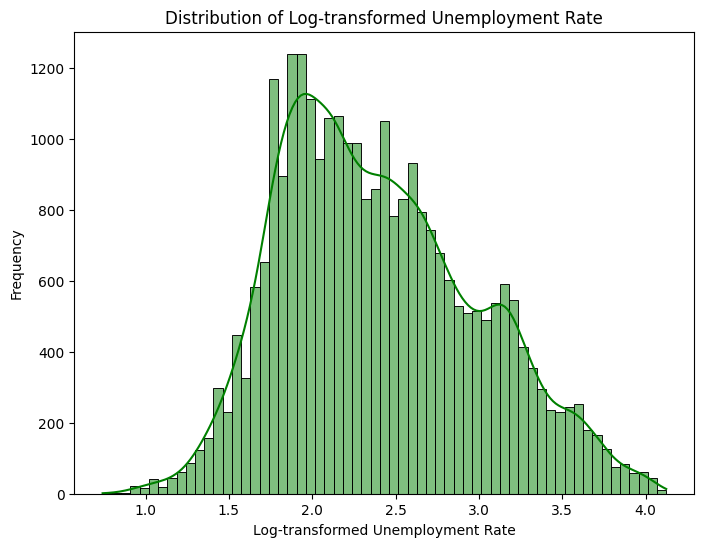

In [343]:
cleaned_df['UNEMPLOYMENT_RATE_LOG'] = np.log1p(cleaned_df['UNEMPLOYMENT_RATE'])

skewness_transformed = cleaned_df['UNEMPLOYMENT_RATE_LOG'].skew()
print(f"Skewness after log transformation: {skewness_transformed}")

plt.figure(figsize=(8, 6))
sns.histplot(cleaned_df['UNEMPLOYMENT_RATE_LOG'], kde=True, color='green')
plt.title('Distribution of Log-transformed Unemployment Rate')
plt.xlabel('Log-transformed Unemployment Rate')
plt.ylabel('Frequency')
plt.show()

If we train and test the data after applying the log transformation method we get data accuracy 1.0, menaing the model is overfitting. We will not use this model but the previous one.

In [344]:
X = cleaned_df.drop(['UNEMPLOYMENT_RATE', 'CLASS', 'CLASS_ENCODED'], axis=1)
y_class = cleaned_df['CLASS']

# Encode categorical features
label_encoder = LabelEncoder()
X['COUNTRY'] = label_encoder.fit_transform(X['COUNTRY'])
X['AGE'] = label_encoder.fit_transform(X['AGE'])
X['SEX'] = label_encoder.fit_transform(X['SEX'])
X['ISO'] = label_encoder.fit_transform(X['ISO'])
X['MONTH'] = label_encoder.fit_transform(X['MONTH'])
X['YEAR'] = label_encoder.fit_transform(X['YEAR'])
X['C2'] = label_encoder.fit_transform(X['C2'])
X['C3'] = label_encoder.fit_transform(X['C3'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Train the model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)
precision = [classification_rep[label]['precision'] for label in class_labels]
recall = [classification_rep[label]['recall'] for label in class_labels]

print(f"Accuracy: {accuracy}")

Accuracy: 1.0


Statistical dataset results.

In [345]:
cleaned_df=cleaned_df.drop(['CLASS','CLASS_ENCODED','UNEMPLOYMENT_RATE_LOG'],axis=1)
cleaned_df.describe()

,NUMERIC,YEAR,UNEMPLOYMENT_RATE
count,28484.000000,28484.000000,28484.000000
mean,382.196672,2014.786547,12.252352
std,212.794062,3.051951,9.029547
min,40.000000,2010.000000,1.100000
25%,208.000000,2012.000000,6.000000
50%,372.000000,2015.000000,9.200000
75%,528.000000,2017.000000,15.400000
max,752.000000,2020.000000,60.800000


In [346]:
result_df = cleaned_df.groupby(['COUNTRY', 'YEAR', 'AGE','C2','C3','ISO','SEX'])['UNEMPLOYMENT_RATE'].mean().reset_index()
# Display the result
print(result_df)

      COUNTRY  YEAR     AGE  C2   C3            ISO SEX  UNEMPLOYMENT_RATE
0     Austria  2010   TOTAL  AT  AUT  ISO 3166-2:AT   F           4.633333
1     Austria  2010   TOTAL  AT  AUT  ISO 3166-2:AT   M           5.008333
2     Austria  2010   TOTAL  AT  AUT  ISO 3166-2:AT   T           4.841667
3     Austria  2010  Y25-74  AT  AUT  ISO 3166-2:AT   F           3.883333
4     Austria  2010  Y25-74  AT  AUT  ISO 3166-2:AT   M           4.291667
...       ...   ...     ...  ..  ...            ...  ..                ...
2463   Sweden  2020  Y25-74  SE  SWE  ISO 3166-2:SE   M           6.171429
2464   Sweden  2020  Y25-74  SE  SWE  ISO 3166-2:SE   T           6.200000
2465   Sweden  2020  Y_LT25  SE  SWE  ISO 3166-2:SE   F          24.314286
2466   Sweden  2020  Y_LT25  SE  SWE  ISO 3166-2:SE   M          26.957143
2467   Sweden  2020  Y_LT25  SE  SWE  ISO 3166-2:SE   T          25.700000

[2468 rows x 8 columns]


In [347]:
import geopandas as gpd
import plotly.express as px
import hvplot.pandas as hvplot
import panel as pn
pn.extension('tabulator')

In [348]:
# Select widgets
selectCountry = pn.widgets.Select(name='Select Country', options=cleaned_df['COUNTRY'].unique().tolist())
selectYear = pn.widgets.Select(name='Select Year', options=cleaned_df['YEAR'].unique().tolist())
selectAge = pn.widgets.Select(name='Select Age', options=cleaned_df['AGE'].unique().tolist())
selectSex = pn.widgets.Select(name='Select Sex', options=cleaned_df['SEX'].unique().tolist())

# Widgets column
selects_column = pn.Column(pn.Row(selectCountry, selectYear), pn.Row(selectAge, selectSex), width=400)

legend_colors = {'Low': 'green', 'Medium': 'yellow', 'High': 'red'}
legend_items = [f'<div style="display: inline-block; margin-right: 5px;margin-left: 7px; background-color: {color}; width: 20px; height: 20px;"></div> {label}<br>' 
                for label, color in legend_colors.items()]
legend_html = f'<div style="background-color: white; padding: 5px; width:130px; color:black">' + " ".join(legend_items) + '</div>'
legend = pn.panel(legend_html, width=300)


def complete_months(data):
    all_months = pd.date_range(start='1/1/2000', end='12/1/2022', freq='MS').strftime('%B')
    return pd.DataFrame(all_months, columns=['MONTH']).merge(data, on='MONTH', how='left')

def update_plot(event):
    selected_country = selectCountry.value
    selected_year = selectYear.value
    selected_age = selectAge.value
    selected_sex = selectSex.value
    
    filtered_df = cleaned_df[(cleaned_df['COUNTRY'] == selected_country) & 
                             (cleaned_df['AGE'] == selected_age) & 
                             (cleaned_df['YEAR'] == selected_year) & 
                             (cleaned_df['SEX'] == selected_sex)]

    all_months_data = complete_months(filtered_df)
    all_months_data['UNEMPLOYMENT_RATE'].fillna(0, inplace=True)
    all_months_data['color'] = pd.cut(all_months_data['UNEMPLOYMENT_RATE'], bins=[-float('inf'), 4, 6, float('inf')],
                                     labels=['Low', 'Medium', 'High'])

    new_bar_plot = all_months_data.hvplot.bar(x='MONTH', y='UNEMPLOYMENT_RATE', color='color',legend=False, 
                                              title=f'Unemployment Rate in {selected_country} ({selected_age}) - {selected_year}',
                                              ylabel='Unemployment Rate', xlabel='Month', ylim=(0, cleaned_df['UNEMPLOYMENT_RATE'].max()+1),
                                              cmap=['green', 'yellow', 'red'])

    # Clear existing elements and add the new ones
    layout = pn.Column(selects_column, pn.Row(new_bar_plot, legend), name="Tab 1")
    dashboard1.clear()
    dashboard1.append(layout)

# Attach the update function to the widgets' on_change event
selectCountry.param.watch(update_plot, 'value')
selectYear.param.watch(update_plot, 'value')
selectAge.param.watch(update_plot, 'value')
selectSex.param.watch(update_plot, 'value')

# Initial plot based on default selections
selected_country = selectCountry.value
selected_year = selectYear.value
selected_age = selectAge.value
selected_sex = selectSex.value

filtered_df = cleaned_df[(cleaned_df['COUNTRY'] == selected_country) & 
                         (cleaned_df['AGE'] == selected_age) & 
                         (cleaned_df['YEAR'] == selected_year) & 
                         (cleaned_df['SEX'] == selected_sex)]

all_months_data = complete_months(filtered_df)
all_months_data['UNEMPLOYMENT_RATE'].fillna(0, inplace=True)
all_months_data['color'] = pd.cut(all_months_data['UNEMPLOYMENT_RATE'], bins=[-float('inf'), 4, 6, float('inf')],
                                 labels=['green', 'yellow', 'red'])

bar_plot = all_months_data.hvplot.bar(x='MONTH', y='UNEMPLOYMENT_RATE', color='color', legend=False,
                                      title=f'Unemployment Rate in {selected_country} ({selected_age}) - {selected_year}',
                                      ylabel='Unemployment Rate', xlabel='Month', ylim=(0, cleaned_df['UNEMPLOYMENT_RATE'].max()+1),
                                      cmap=['green', 'yellow', 'red'])

dashboard1 = pn.Column(
    '# Unemplyment rate based on country, year, age and sex',
    selects_column, 
    pn.Row(bar_plot, legend), 
    name="Tab 2")

dashboard1.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'03388d75-b426-4c60-91c9-207dc78d8793': {'version…

In [349]:
import holoviews as hv
result_df_1 = result_df
def plot_most_affected_group(country):
    result_df_filtered = result_df_1[(result_df_1['COUNTRY'] == country) & (result_df_1['YEAR'].isin([2019, 2020])) & (result_df_1['AGE'].isin(['Y_LT25', 'Y25-74'])) & (result_df_1['SEX'].isin(['F', 'M']))]    

    result_df_sum = result_df_filtered.groupby(['AGE', 'SEX'])['UNEMPLOYMENT_RATE'].sum().reset_index()

    most_affected_group = result_df_sum.loc[result_df_sum['UNEMPLOYMENT_RATE'].idxmax()]

    plot = hv.Bars(result_df_sum, ['AGE', 'SEX'], 'UNEMPLOYMENT_RATE', label=f'Most Affected Group: {most_affected_group["AGE"]} ({most_affected_group["SEX"]})')

    return plot.opts(
        title=f'Unemployment rate in {country} during 2019 and 2020',
        ylabel='Total Unemployment Rate',
        width=400
    )

country_selector = pn.widgets.Select(name='Country', options=result_df['COUNTRY'].unique().tolist())

@pn.depends(country_selector.param.value)
def update_most_affected_plot(country):
    return plot_most_affected_group(country)

dashboard3 = pn.Column(
    '# Most Affected Age and Sex Group by COVID-19 pandemic',
    country_selector,
    update_most_affected_plot,
    name="Tab 2"
)

dashboard3.servable()


BokehModel(combine_events=True, render_bundle={'docs_json': {'36c6852e-eb78-4459-8882-34c60dc484f2': {'version…

In [350]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
new_result_df=result_df[(result_df['AGE'] == 'TOTAL') & (result_df['SEX'] == 'T')]

merged_df = world.merge(new_result_df, how='left', left_on='iso_a3', right_on='C3')

def create_map(year):
    filtered_df = merged_df[merged_df['YEAR'] == year]
    
    fig = px.choropleth_mapbox(
        filtered_df,
        geojson=filtered_df.geometry,
        locations=filtered_df.index,
        color='UNEMPLOYMENT_RATE',
        hover_name='COUNTRY',
        title=f'Unemployment Rate in {year}',
        color_continuous_scale='viridis',
        range_color=(new_result_df['UNEMPLOYMENT_RATE'].min(), new_result_df['UNEMPLOYMENT_RATE'].max()),
        mapbox_style="carto-positron",
        center={"lat": 48, "lon": 17},
        zoom=2,
    )

    return fig

year_selector = pn.widgets.Select(options=new_result_df['YEAR'].unique().tolist())

def update_map(event):
    year = year_selector.value
    map_plot = create_map(year)
    map_panel.object = map_plot

year_selector.param.watch(update_map, 'value')

initial_year = new_result_df['YEAR'].min()
map_plot = create_map(initial_year)

map_panel = pn.pane.Plotly(map_plot)

layout = pn.Column(
    '# Average Unemployment Rate for European Union countries',
    '## Select year: ',
    year_selector,
    map_panel,
    name="Tab 1"
)
layout.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'5188815c-8f09-4461-9a05-fe5a5829fece': {'version…

In [351]:
tabs = pn.Tabs(layout, dashboard1, dashboard3)

tabs.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'b3d8ca53-3a0e-4c17-83c7-6431ddf88f49': {'version…